In [43]:
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, fsolve

### Preprocessing dropna for no date

In [2]:
data = pd.read_csv('A4_Kulhuse.csv').dropna(how='all')
data.iloc[[4604, 4605, 4606,4607,4608,4609, 4610]]

,Temp,Sal,Depth,pH,Chl,ODOsat,ODO,Battery,DateTime
4604,5.55,18.75,5.167,0.89,4.67,95.9,10.66,11.7,2017-11-28 08:30:55
4605,5.53,18.73,5.167,1.00,4.47,95.9,10.66,11.7,2017-11-28 09:00:54
4606,4.39,1.37,-0.235,0.33,0.45,95.9,12.33,11.8,2017-11-28 09:30:55
4608,4.49,1.32,-0.246,7.24,0.60,98.2,12.60,12.9,2017-11-28 10:00:00
4609,5.31,18.43,4.856,8.08,4.50,97.4,10.92,12.7,2017-11-28 10:30:00
4610,5.24,18.45,4.846,8.09,4.30,97.2,10.91,12.7,2017-11-28 11:00:00
4611,5.45,18.72,4.838,8.10,4.70,97.0,10.81,12.7,2017-11-28 11:30:00


# Question 4.1

In [3]:
data['DateTime'] = pd.to_datetime(data["DateTime"])

In [4]:
dates = data['DateTime'].values
sal = data['Sal'].values
sal_na_mask = np.where(np.isnan(sal)==False)[0]
o2 = data['ODO'].values
o2_na_mask = np.where(np.isnan(o2)==False)[0]

mask = sal_na_mask ## the two masks are the same

In [5]:
np.where(np.isnan(sal))

(array([1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597,
        1598, 1599, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608,
        1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619,
        1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630,
        1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641,
        1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652,
        1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663,
        1664, 1665, 1666, 1667, 1668, 1669, 1670, 1671, 1672, 1673, 1674,
        1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682, 1683, 1684, 1685,
        1686, 1687, 1688, 1689, 1690, 1691, 1819, 1886, 2312, 2326, 2342]),)

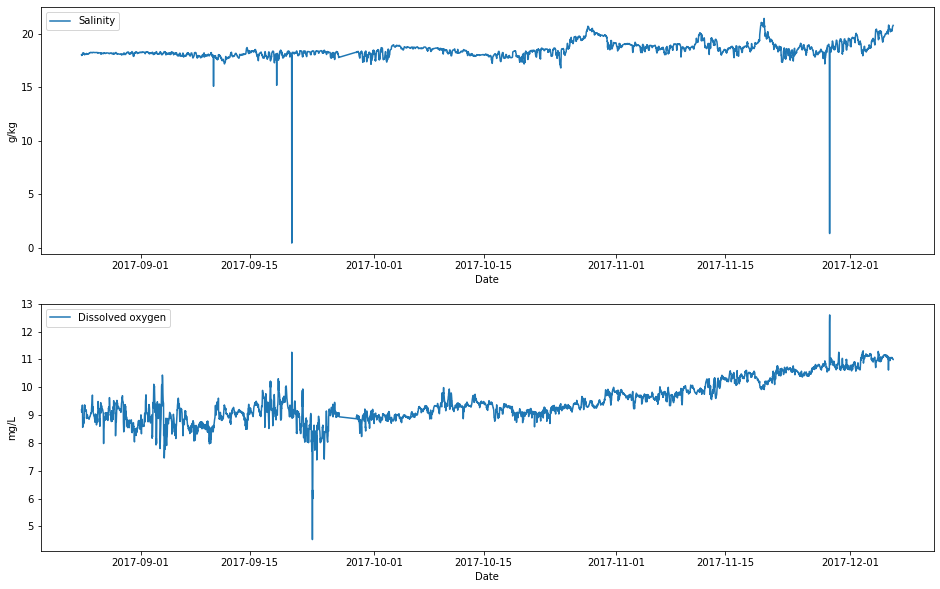

In [6]:
plt.figure(figsize=(16,10))
plt.subplot(2,1,1)
plt.plot_date(dates[sal_na_mask], sal[sal_na_mask], linestyle='-', marker=None)
plt.legend(['Salinity'])
plt.xlabel('Date')
plt.ylabel('g/kg')
plt.subplot(2,1,2)
plt.plot_date(dates[o2_na_mask], o2[o2_na_mask], linestyle='-', marker=None)
plt.legend(['Dissolved oxygen'], loc=2)
plt.xlabel('Date')
plt.ylabel('mg/L')
plt.show()

### Early comments: 
* Salinity: overall quite stationary with some big outliers. Also variance seems to increase with time: variations are bigger on the right side of the plot.
* First stable with a big variance then it seems to get a positive linear trend with a reduced variance. Still a few outliers but smaller than for salinity.

Missing values are found at the same place in both plots, the most obvious example of this occured at the end of September. It happened several time later but during a smaller period which makes it invisible on the plots. We dealt with it as if no measurement was done during this period of time. May be that the sensor was off during a few hours/days. 

# Implementation of the kalman function and check for correctness

In [74]:
'''
Kalman filtering function:
    perform the reconstruction and prediction step on the given data and returns predictions, reconstruction and variances
    
    -x0: initial state
    -V0: initial variance
    -us: known inputs to the system
    -ys: observed values of the system
    -A, B, C: state space model matrices
    -sig_1: system variance matrix
    -sig_2: observation variance matrix

''' 


def kalman_filtering(x0, us, ys, A, B, C, sig_1, sig_2,V0=None, check_outlier=False, print_enabled=True):
    ## initialization
    x_pred = x0
    
    # use state variance as initial variance if not specified
    sig_xx_pred = sig_1 
    if V0 is not None: 
        sig_xx_pred = V0
        
    sig_yy_pred = C@sig_xx_pred@C.T + sig_2

    # keep track of variance, predictions and reconstructions
    sigmas_xx = [sig_xx_pred]
    sigmas_yy = [sig_yy_pred]
    
    sigmas_xx_recon = [sig_xx_pred]
    sigmas_yy_recon = [sig_yy_pred]
    
    predictions = [x0]
    reconstructions = [x0]

    outliers = []
    
    for i in range(1, len(ys)):        
        ## reconstruction
        
        # if the data is observed and if it is not an outlier perform reconstruction
        if not np.isnan(ys[i]) and (not check_outlier or abs(ys[i] - x_pred) < 6 * np.sqrt(sig_yy_pred[0,0])):
            K = sig_xx_pred@C.T@np.linalg.inv(sig_yy_pred)
            x_recon = x_pred + K@(ys[i]-C@x_pred)
            sig_xx_recon = sig_xx_pred - K@sig_yy_pred@K.T
            
        # if it's an outlier skip reconstruction and keep track of outlier
        elif check_outlier and abs(ys[i] - x_pred) > 6 * np.sqrt(sig_xx_pred[0,0]):
            outliers.append(i)
            x_recon = x_pred
            sig_xx_recon = sig_xx_pred
            
        # if data is not observed skip reconstruction
        else:
            x_recon = x_pred
            sig_xx_recon = sig_xx_pred
            
        ## prediction
        x_pred = A@x_recon + B*us[i]
        sig_xx_pred = A@sig_xx_recon@A.T + sig_1
        sig_yy_pred = C@sig_xx_pred@C.T + sig_2
        
        ## keep track of predictions and variances
        predictions.append(x_pred)
        reconstructions.append(x_recon)
        
        sigmas_xx.append(sig_xx_pred)
        sigmas_yy.append(sig_yy_pred)
        
        sigmas_xx_recon.append(sig_xx_recon)
        sigmas_yy_recon.append(C@sig_xx_recon@C.T + sig_2)
        
    ## print some information
    if check_outlier and print_enabled:
        print('Data filtered, %d outliers found: %s'%(len(outliers), outliers))
    elif print_enabled:
        print('Data filtered')
    return predictions, reconstructions, sigmas_xx, sigmas_yy, sigmas_xx_recon, sigmas_yy_recon
        
        

In [8]:
'''
Plotting function:
    given the ouput of the kalman_filtering, plots for each variables in the predictions, 
    the predicted values alongsides with a confidence interval and the real values.

''' 

def plot_kalman(pred, sigmas_xx, sigmas_yy, time, real_val, C, names=None, isDates=True, mask=None, n_min=0, n_max=None):
    
    predictions = np.array(pred).T
    if len(predictions.shape)==3:
        predictions = predictions[0]
    sigmas_xx = np.array(sigmas_xx)
    sigmas_yy = np.array(sigmas_yy)
    n = predictions.shape[0]
    
    if n_max is None:
        n_max = predictions.shape[1]
    
    if mask is None:
        mask = np.arange(0, predictions.shape[1])  
    plt.figure(figsize=(16,5*n))
    for i, var in enumerate(predictions):
        plt.subplot(n, 1, i+1)
        if C[0,i] != 0:
            interval = 1.96 * np.sqrt(sigmas_yy[:,0,0])
        else:
            interval = 1.96 * np.sqrt(sigmas_xx[:,i,i])
            
        if isDates:
            plt.plot_date(time[mask][n_min:n_max], real_val[mask, i][n_min:n_max], linestyle='-', marker=None)
            plt.plot_date(time[n_min:n_max], var[n_min:n_max], linestyle='-', marker=None)
            plt.fill_between(time[n_min:n_max] ,(var[n_min:n_max] + interval[n_min:n_max]).tolist(), (var[n_min:n_max] - interval[n_min:n_max]).tolist(), color='lightblue', alpha=0.6)
            if names is not None:
                plt.legend([names[i]+'real values', names[i] + 'predictions', '95% confidence interval'])
            else:
                plt.legend(['Real values', 'Predictions', '95% confidence interval'])
        else:
            plt.plot(time[n_min:n_max], real_val[mask,i][n_min:n_max], linestyle='-', marker='+')
            plt.plot(time[n_min:n_max], var[n_min:n_max], linestyle='-', marker=None)
            plt.fill_between(time[n_min:n_max], (var[n_min:n_max] + interval[n_min:n_max]).tolist(), (var[n_min:n_max] - interval[n_min:n_max]).tolist(), color='lightblue', alpha=0.6)

            if names is not None:
                plt.legend([names[i]+' real values', names[i] + ' predictions', '95% confidence interval'])
            else:
                plt.legend(['Real values', 'Predictions', '95% confidence interval'])
    plt.show()

## Check implementation on free fall problem

In [9]:
def remove_values(array, n=10):
    array[np.random.randint(0, array.size, n)]= np.nan

In [10]:
parabol = np.array([-t*t*9.81/2 + 100*t+10000+np.random.randn(1)[0]*100 for t in range(40)])
remove_values(parabol,n=15)
speed = np.array([-t*9.81 + 100 for t in range(40)])
real_values = np.stack((parabol, speed)).T

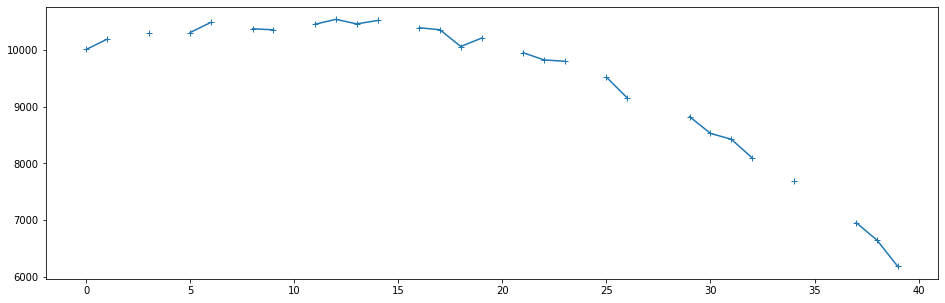

In [11]:
plt.figure(figsize=(16,5))
plt.plot(parabol[:300], marker='+')

In [12]:
A = np.array([[1,1], [0,1]])
B = np.array([[-0.5],[-1]])
C = np.array([[1, 0]])
x0 = np.array([[9750],[0]])
u = np.ones((40,1))*9.81
pred, recon, sig_xx, sig_yy , sig_xx_recon, sig_yy_recon=kalman_filtering(x0, u, parabol, A, B, C, 10000*np.array([[2,0.8], [0.8,1]]), 10000*np.eye(1), V0=0.1*np.array([[2,0.8], [0.8,1]]))

Data filtered


In [13]:
np.array(recon)[-1]

array([[6212.53023944],
       [-372.9736928 ]])

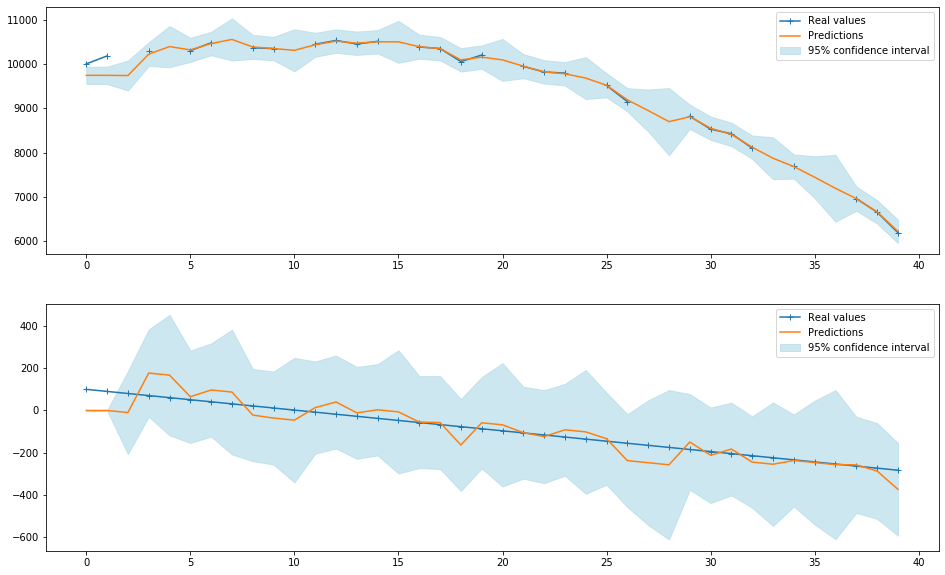

In [14]:
plot_kalman(recon, sig_xx_recon, sig_yy_recon, np.arange(0,500), real_values, C=C, isDates=False)

## Compare with existing library

In [15]:
from filterpy.kalman import KalmanFilter
f = KalmanFilter (dim_x=2, dim_z=1)

In [16]:
f = KalmanFilter (dim_x=1, dim_z=1)
A = np.array([[1]])
B = np.array([[0]])
C = A
x0 = np.array([18])
u = np.zeros((sal.size,1))

f.x = x0
f.F = A
f.H = C
f.P = 0.01*np.eye(1)
f.B = B


predictions = []
for i in range(0,4999):
    f.predict()
    f.update(sal[i])
    predictions.append(f.x)

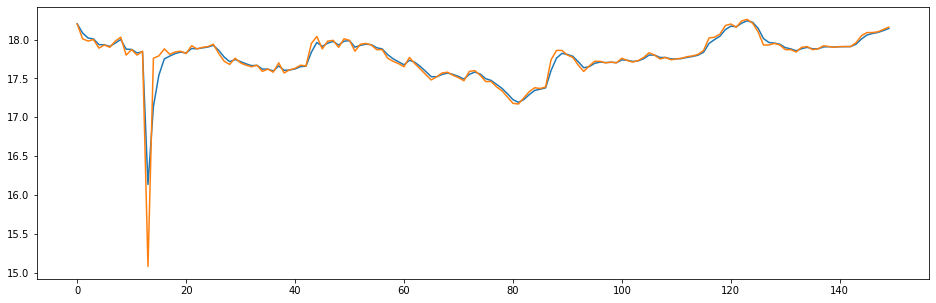

In [17]:
plt.figure(figsize=(16,5))
plt.plot(np.array(predictions)[800:950,0])
plt.plot(sal[800:950])

Does not deal with NaN values that is why it stopped at step ~1600. However it look very similar to our filtering.

# Question 4.3: Apply on salinity

In [18]:
A = np.array([[1]])
B = np.array([[0]])
C = A
x0 = np.array([18])
u = np.zeros((sal.size,1))

In [19]:
pred, recon, sig_xx, sig_yy , sig_xx_recon, sig_yy_recon = kalman_filtering(x0, u, sal, A, B, C, 0.01*np.eye(1), 0.005*np.eye(1), check_outlier=False)

Data filtered


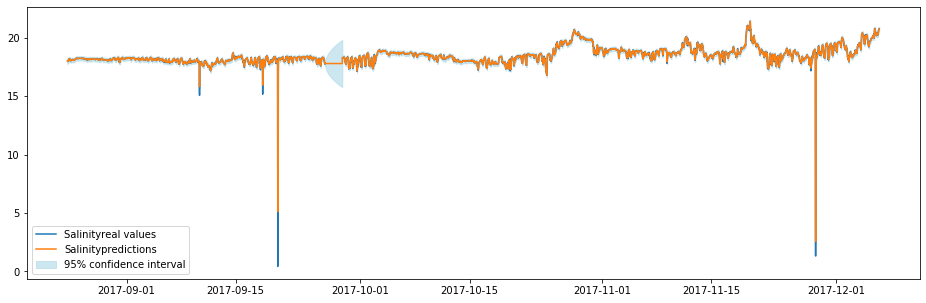

In [20]:
plot_kalman(recon, sig_xx_recon, sig_yy_recon, dates, np.array([sal]).T, C=C, names=['Salinity'])

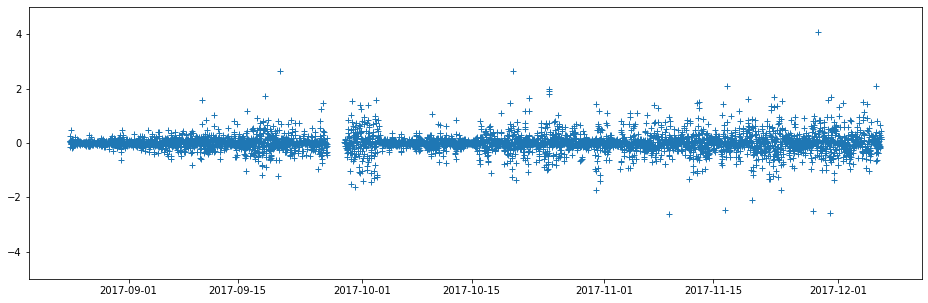

In [21]:
errors = (sal-np.array(recon)[:, 0].astype(float))
sd_errors = np.std(errors[~np.isnan(errors)])


# normalized_errors = np.log(errors/np.sqrt(np.array(sig_yy)[~np.isnan(sig_yy)]))
normalized_errors = errors/np.sqrt(np.array(sig_yy_recon)[~np.isnan(sig_yy_recon)])

plt.figure(figsize=(16,5))
# plt.plot_date(dates,errors, linestyle='-', marker=None)
# plt.scatter(np.array(pred),normalized_errors, marker='+')
plt.ylim([-5,5])
plt.plot_date(dates,normalized_errors, marker='+', markerfacecolor='none')

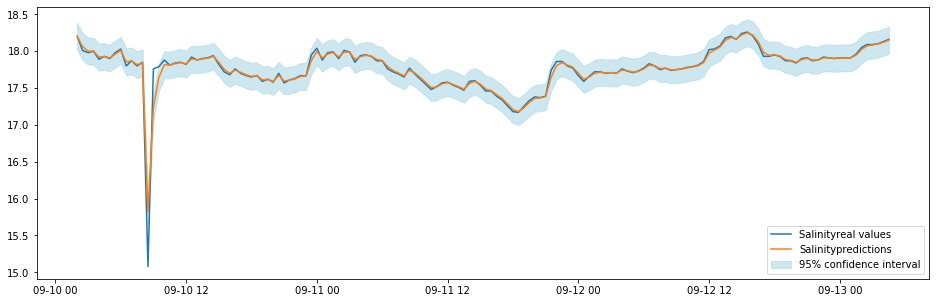

In [22]:
plot_kalman(recon, sig_xx_recon, sig_yy_recon, dates, np.array([sal]).T,C=C, names=['Salinity'], n_min=800,n_max=950)

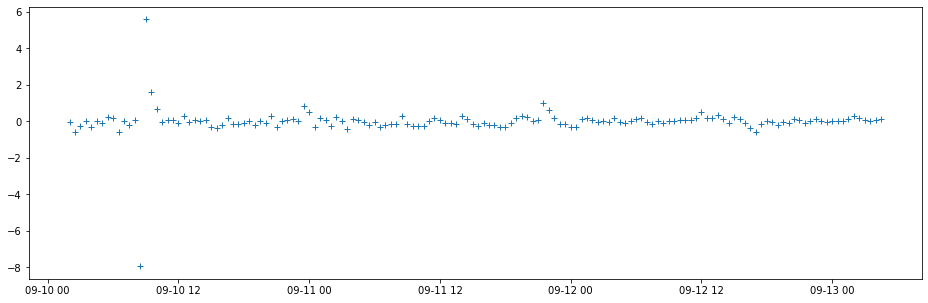

In [23]:
plt.figure(figsize=(16,5))
plt.plot_date(dates[800:950],normalized_errors[800:950], marker='+', markerfacecolor='none')

In [24]:
np.array(recon)[4998,0]

20.758150131965277

In [25]:
1.96 * np.sqrt(np.array(sig_yy_recon)[4998,0,0])

0.1823985523840115

# Question 4.4 Skip outliers

Data filtered, 10 outliers found: [813, 1202, 1295, 2732, 3691, 4037, 4577, 4606, 4607, 4684]


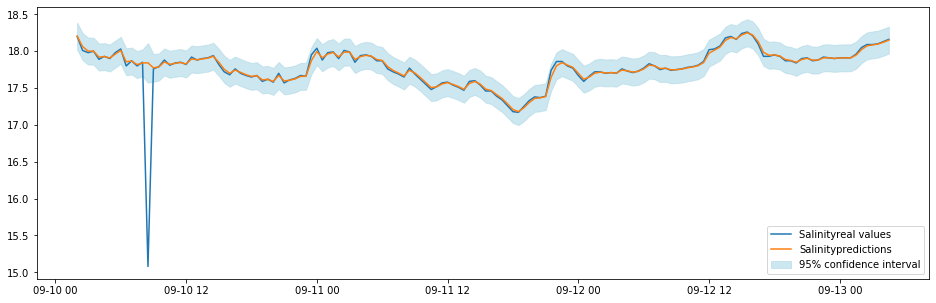

In [75]:
A = np.array([[1]])
B = np.array([[0]])
C = A
x0 = np.array([18])
u = np.zeros((sal.size,1))
pred, recon, sig_xx, sig_yy , sig_xx_recon, sig_yy_recon = kalman_filtering(x0, u, sal, A, B, C, 0.01*np.eye(1), 0.005*np.eye(1), check_outlier=True)
plot_kalman(recon, sig_xx_recon, sig_yy_recon, dates, np.array([sal]).T, C=C, names=['Salinity'], n_min=800,n_max=950)

In [27]:
np.array(recon)[4998,0]

20.758150131965277

In [28]:
1.96 * np.sqrt(np.array(sig_yy_recon)[4998,0,0])

0.1823985523840115

# Question 4.5

In [29]:
def ml_estimate_salinity(params):
    A = np.array([[1]])
    B = np.array([[0]])
    C = A
    u = np.zeros((sal.size,1))
    
    x0 = np.array([16])
    
    sig_1 = np.exp(params[0])*np.eye(1)
    sig_2 = np.exp(params[1])*np.eye(1)

    pred, recon, sig_xx, sig_yy, sig_xx_recon, sig_yy_recon = kalman_filtering(x0, u, sal, A, B, C, sig_1, sig_2, print_enabled=False)
    
    errors = np.reshape(sal-np.array(recon)[:, 0].astype(float), (-1,1))
    
    loglikelyhood = 0

    for i in range(len(errors)):
        if not np.isnan(errors[i]):
            sign_logdet, logdet = np.linalg.slogdet(sig_yy_recon[i])
            loglikelyhood +=0.5 * (logdet + errors[i].T@np.linalg.inv(sig_yy_recon[i])@errors[i]) # negative loglikelyhood
    return loglikelyhood

In [30]:
ml_estimate_salinity([np.log(0.01), np.log(0.01)])

-4785.568224732269

In [31]:
optim_params = minimize(ml_estimate_salinity, np.array([np.log(1), np.log(0.05)]), method='l-bfgs-b', bounds=[(None, None), (np.log(2.6e-3), None)])

In [32]:
optim_params

      fun: -12853.495510875515
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.18278728e-02, 2.44175535e+03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 75
      nit: 6
   status: 0
  success: True
        x: array([ 0.03591436, -5.95224383])

In [33]:
np.exp(optim_params.x)

array([1.03656707, 0.0026    ])

### Parameter variance

In [60]:
optim_params.hess_inv.todense()

array([[ 0.85477555, -0.66177124],
       [-0.66177124,  0.92953995]])

In [61]:
var_log_domain = optim_params.hess_inv(optim_params.x) # working on negative log likelihood therefore variance is the hessian inverse not -H^-1
var = np.exp(optim_params.x)**2*var_log_domain - 1/4*np.exp(optim_params.x)**2*var_log_domain**2
print('Params variance, log domain:', var_log_domain)
print('Params variance:', var)

Params variance, log domain: [ 3.96972251 -5.55661554]
Params variance: [ 3.22860435e-02 -8.97431210e-05]


In [47]:
np.exp(-optim_params.hess_inv.todense())

array([[0.42537866, 1.93822236],
       [1.93822236, 0.39473527]])

## Fit the optimal model

In [76]:
A = np.array([[1]])
B = np.array([[0]])
C = A
u = np.zeros((sal.size,1))

sig_1 = np.exp(optim_params.x[0])*np.eye(1)
sig_2 = np.exp(optim_params.x[1])*np.eye(1)



x0 = np.array([18])


pred, recon, sig_xx, sig_yy, sig_xx_recon, sig_yy_recon =kalman_filtering(x0, u, sal, A, B, C, sig_1, sig_2,check_outlier=True, print_enabled=True)

Data filtered, 3 outliers found: [1295, 4606, 4607]


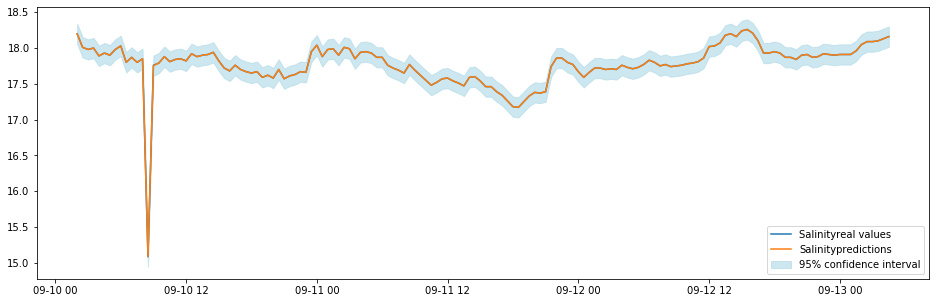

In [36]:
plot_kalman(recon, sig_xx_recon, sig_yy_recon, dates, np.array([sal]).T,C=C, names=['Salinity'], n_min=800,n_max=950)

In [77]:
np.array(recon)[4998,0]

20.769924877126993

In [78]:
1.96 * np.sqrt(np.array(sig_yy_recon)[4998,0,0])

0.14124939575113302

# Question 4.6

In [85]:
DOs = []
DO = 10
DOsat = 12
alpha=0.5
for i in range(200):
    DOs.append(DO)
    DO = (1-alpha)*DO + alpha*DOsat

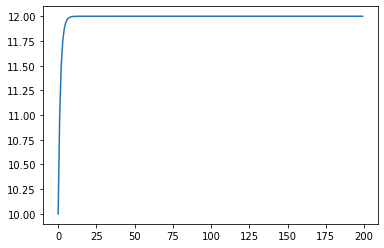

In [86]:
plt.plot(DOs)